In [1]:
!pip install datasets transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast
from safetensors.torch import save_file
import numpy as np
import os

In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

<ipython-input-4-18a5c652257b>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
dataset = load_dataset("JLB-JLB/seizure_eeg_dev")

# Custom dataset class
class SeizureEEGDataset(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.data = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        if image.mode != 'L':
            image = image.convert('L')
        label = self.data[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Create datasets
full_dataset = SeizureEEGDataset(dataset, split='train', transform=transform)

# Create train/validation split
torch.manual_seed(42) # for reproducability
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Hyperparameters
batch_size = 1024
num_epochs = 30
learning_rate = 0.001

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# CHECKPOINT RETRIEVAL
# # Load the checkpoint
# checkpoint = torch.load('checkpoints/checkpoint_epoch_4.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

# # Restore optimizer state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Restore scaler state (for mixed precision training)
# scaler.load_state_dict(checkpoint['scaler'])

# # Set the starting epoch
# start_epoch = checkpoint['epoch'] + 1

# # Restore best validation loss and history
# best_val_loss = checkpoint['best_val_loss']
# train_losses = checkpoint['train_losses']
# val_losses = checkpoint['val_losses']
# val_accuracies = checkpoint['val_accuracies']

# print(f"Resuming training from epoch {start_epoch}")

# for epoch in range(start_epoch, num_epochs):

In [ ]:
best_val_loss = np.inf
train_losses = []
val_losses = []
val_accuracies = []

# early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# checkpoint
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100. * correct / total
    val_accuracies.append(val_accuracy)

    # save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler': scaler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, f'{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pt')

    # save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(checkpoint, f'{checkpoint_dir}/best_model.pt')
        save_file(model.state_dict(), "eeg_classifier.safetensors")
        print(f"Saved new best model with validation loss: {best_val_loss:.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training finished!")

<ipython-input-11-a530376c4980>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Saved new best model with validation loss: 0.2612
Epoch [1/30], Train Loss: 0.3230, Val Loss: 0.2612, Val Accuracy: 93.17%


ValueError: x and y must have same first dimension, but have shapes (30,) and (12,)

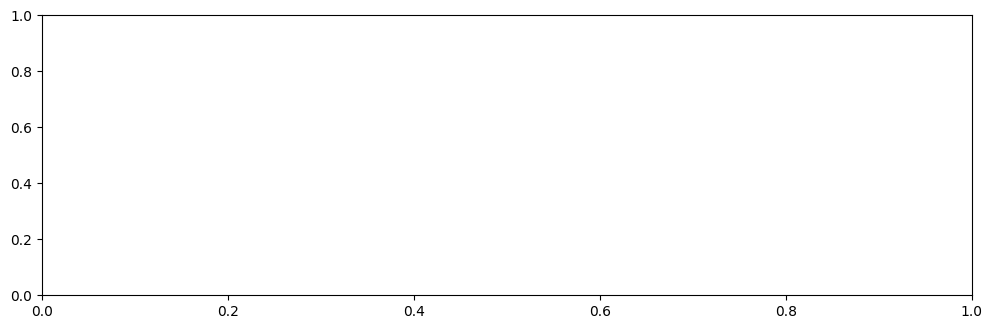

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# save safetensors
model_state_dict = model.state_dict()
save_file(model_state_dict, "eeg_classifier.safetensors")
torch.save(model, 'eeg_classifier.pth')

In [ ]:
import json

model.load_state_dict(torch.load('path_to_your_model.pth'))

torch.save(model, 'eeg_classifier_full.pth')
save_file(model.state_dict(), "eeg_classifier.safetensors")

def get_model_info(model):
    return {
        'class_name': model.__class__.__name__,
        'layers': [
            {
                'name': name,
                'type': str(type(module).__name__),
                'parameters': {k: v.tolist() if isinstance(v, torch.Size) else v
                               for k, v in module.__dict__.items() if not k.startswith('_')}
            } for name, module in model.named_modules() if not isinstance(module, torch.nn.Sequential)
        ]
    }

model_info = get_model_info(model)
with open('config.json', 'w') as f:
    json.dump(model_info, f, indent=2)

In [ ]:
# evaluation
dataset = load_dataset("JLB-JLB/seizure_eeg_eval")

def create_balanced_dataset(dataset, num_samples_per_class=500):
    balanced_data = {
        'image': [],
        'label': []
    }

    for label in [0, 1, 2]:  # Assuming 3 classes
        class_data = [item for item in dataset['train'] if item['label'] == label]
        selected_data = class_data[:num_samples_per_class]

        balanced_data['image'].extend([item['image'] for item in selected_data])
        balanced_data['label'].extend([item['label'] for item in selected_data])

    return balanced_data

balanced_test_data = create_balanced_dataset(dataset)
balanced_test_dataset = SeizureEEGDataset(balanced_test_data, split='train', transform=transform)
balanced_test_dataloader = DataLoader(balanced_test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# evaluation
model.eval()
total_correct = 0
total_samples = 0
class_correct = [0, 0, 0]
class_total = [0, 0, 0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, labels in balanced_test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

accuracy = (total_correct / total_samples) * 100
print(f'Balanced Test Set Accuracy: {accuracy:.2f}%')

for i in range(3):
    class_accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of class {i}: {class_accuracy:.2f}%')

Test Accuracy: 0.95


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in balanced_test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()